In [1]:
from vivit import run_experiment, test_files, classes
from data import get_video_label, VideoDataGenerator, labels_df, files, labels, num_to_label, files
from synthetic import *
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import synthetic

In [2]:
classes = list(labels_df.groupby('label').size().sort_values(ascending=False)[:10].index)
good_classes = ['book', "drink", "go", "chair", "who", "clothes", "yes", "year", "thin", "fine"]
test_files = [f for f in files if labels[int(os.path.basename(f).split('.')[0])] in good_classes]
base = "../data/videos"
for video, f in enumerate(test_files):
    name = os.path.basename(f)
    if not os.path.exists(f"{base}/flipped/{name}"):
        synthetic.flip_video(f"{base}/original/{name}", f"{base}/flipped/{name}")
    if not os.path.exists(f"{base}/rotated_90/{name}"):
        synthetic.rotate_video(f"{base}/original/{name}", f"{base}/rotated_90/{name}", 90)
    if not os.path.exists(f"{base}/rotated_270/{name}"):
        synthetic.rotate_video(f"{base}/original/{name}", f"{base}/rotated_270/{name}", 270)
    if not os.path.exists(f"{base}/noised/{name}"):
        synthetic.noise_video(f"{base}/original/{name}", f"{base}/noised/{name}")
    print(f"{video+1}/{len(test_files)}", end = '\r')
all_files = []
for folder in ["original", "flipped", "rotated_90", "rotated_270", "noised"]:
    all_files += [f"{base}/{folder}/{os.path.basename(f)}" for f in test_files]
y = [get_video_label(f) for f in all_files]
X_train, X_test, y_train, y_test = train_test_split(all_files, y, test_size=0.2, random_state=42, stratify=y)
train, validation = VideoDataGenerator(X_train), VideoDataGenerator(X_test)

In [3]:
model = keras.models.load_model("../models/high-epoch.keras")

2024-04-23 19:25:47.707368: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-04-23 19:25:47.707390: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-23 19:25:47.707394: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-23 19:25:47.707429: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-23 19:25:47.707446: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
model.evaluate(validation, verbose=1)

2024-04-23 19:25:50.280739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 517ms/step - accuracy: 0.7928 - loss: 0.9922 - top-5-accuracy: 0.9540


[1.0250496864318848, 0.7849056720733643, 0.9584905505180359]

In [5]:
# make predictions on the testing set
preds = model.predict(validation, verbose=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 885ms/step


In [6]:
labels = [num_to_label[p] for p in np.argmax(preds, axis=1)]
true_labels = [num_to_label[p] for p in y_test]
predictions = pd.DataFrame({"true": true_labels, "predicted": labels})
predictions["correct"] = predictions["true"] == predictions["predicted"]
predictions["confidence"] = [preds[i][np.argmax(preds[i])] for i in range(len(preds))]

In [36]:
top_5_labels = [np.argsort(p)[::-1][:5] for p in preds]
top_5_labels = [[num_to_label[l] for l in p] for p in top_5_labels]
predictions["top_5"] = top_5_labels
predictions['in_top_5'] = [true_labels[i] if true_labels[i] in top_5_labels[i] else true_labels[0] for i in range(len(true_labels))]
predictions.to_csv("../data/predictions.csv", index=False)
predictions

,true,predicted,correct,confidence,top_5,in_top_5
0,clothes,clothes,True,0.988084,"[clothes, chair, year, book, go]",clothes
1,clothes,thin,False,0.604135,"[thin, fine, who, yes, year]",clothes
2,thin,thin,True,0.955884,"[thin, who, fine, year, drink]",thin
3,go,go,True,0.997409,"[go, fine, yes, book, chair]",go
4,who,who,True,0.874774,"[who, year, book, fine, yes]",who
...,...,...,...,...,...,...
260,book,book,True,0.995829,"[book, chair, year, clothes, who]",book
261,go,go,True,0.976923,"[go, chair, yes, fine, drink]",go
262,clothes,clothes,True,0.981781,"[clothes, book, chair, year, who]",clothes
263,clothes,clothes,True,0.992463,"[clothes, year, chair, book, go]",clothes


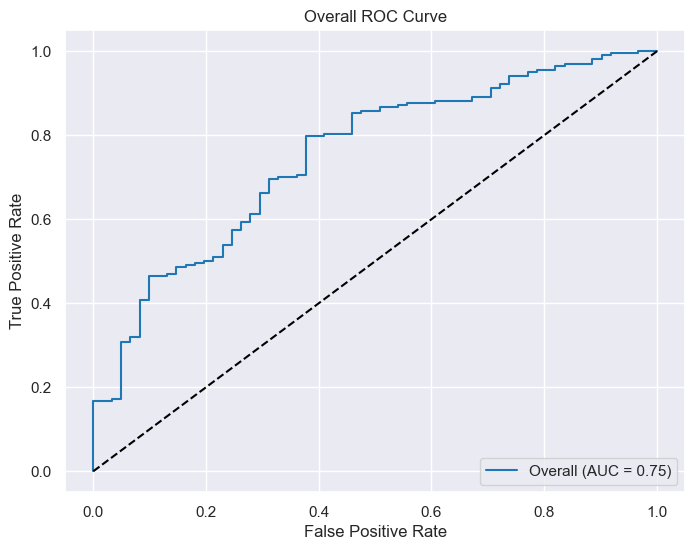

In [34]:
# make ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix

correct_predictions = (predictions["true"] == predictions["predicted"]).astype(int)
overall_confidence = predictions['confidence']  # Confidence is directly used as the probability score

# Calculate the overall ROC curve and AUC
fpr_overall, tpr_overall, _ = roc_curve(correct_predictions, overall_confidence)
roc_auc_overall = auc(fpr_overall, tpr_overall)

# Plot the overall ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_overall, tpr_overall, label=f'Overall (AUC = {roc_auc_overall:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.title('Overall ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

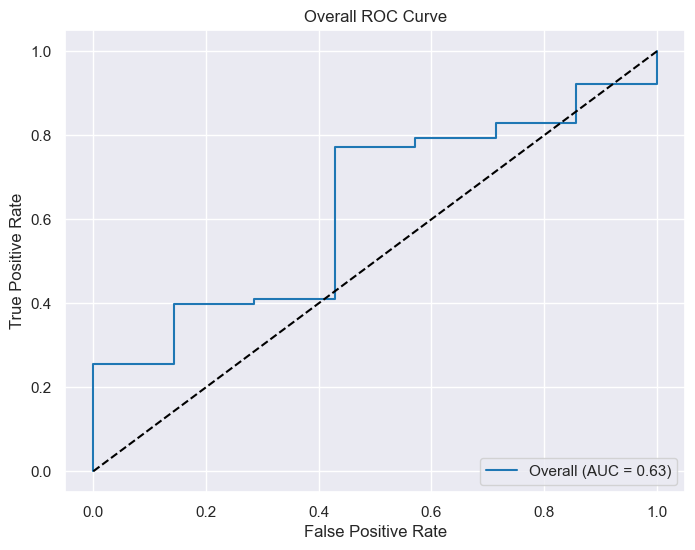

In [35]:
correct_predictions = (predictions["true"] == predictions["in_top_5"]).astype(int)
overall_confidence = predictions['confidence']  # Confidence is directly used as the probability score

# Calculate the overall ROC curve and AUC
fpr_overall, tpr_overall, _ = roc_curve(correct_predictions, overall_confidence)
roc_auc_overall = auc(fpr_overall, tpr_overall)

# Plot the overall ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_overall, tpr_overall, label=f'Overall (AUC = {roc_auc_overall:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.title('Overall ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [8]:
def top_n_accuracy(n):
    return np.mean([true_labels[i] in top_5_labels[i][:n] for i in range(len(true_labels))])
for i in range(1, 6):
    print(f"Top {i} accuracy: {top_n_accuracy(i)}")

Top 1 accuracy: 0.769811320754717
Top 2 accuracy: 0.8754716981132076
Top 3 accuracy: 0.9245283018867925
Top 4 accuracy: 0.9547169811320755
Top 5 accuracy: 0.9622641509433962


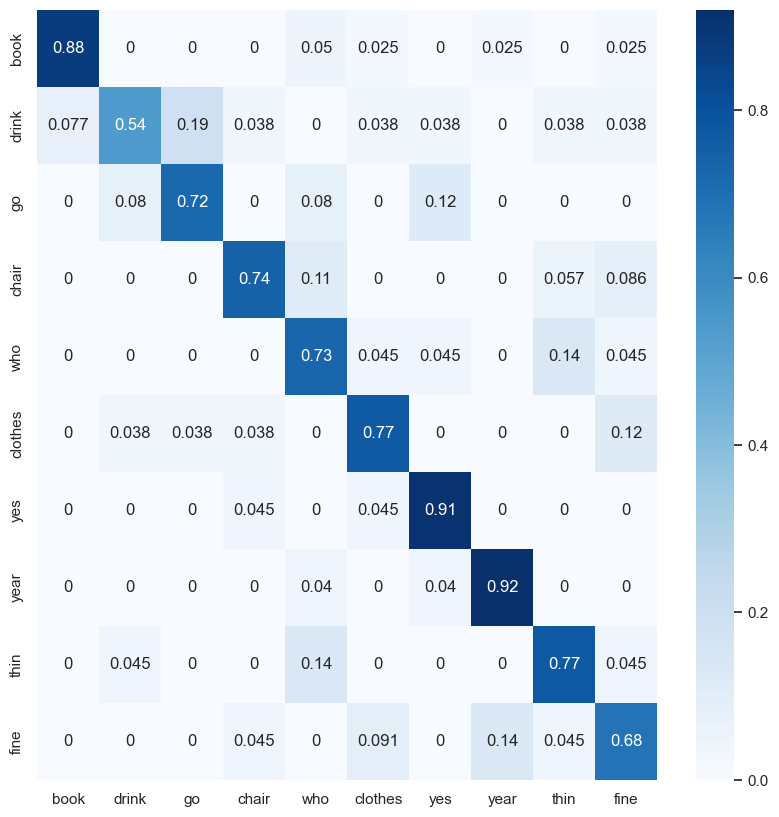

In [11]:
cm = confusion_matrix(true_labels, labels, normalize='true')
# make seaborn heatmap
import seaborn as sns
sns.set(style="darkgrid", palette="tab10")
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, xticklabels=good_classes, yticklabels=good_classes, cmap='Blues');

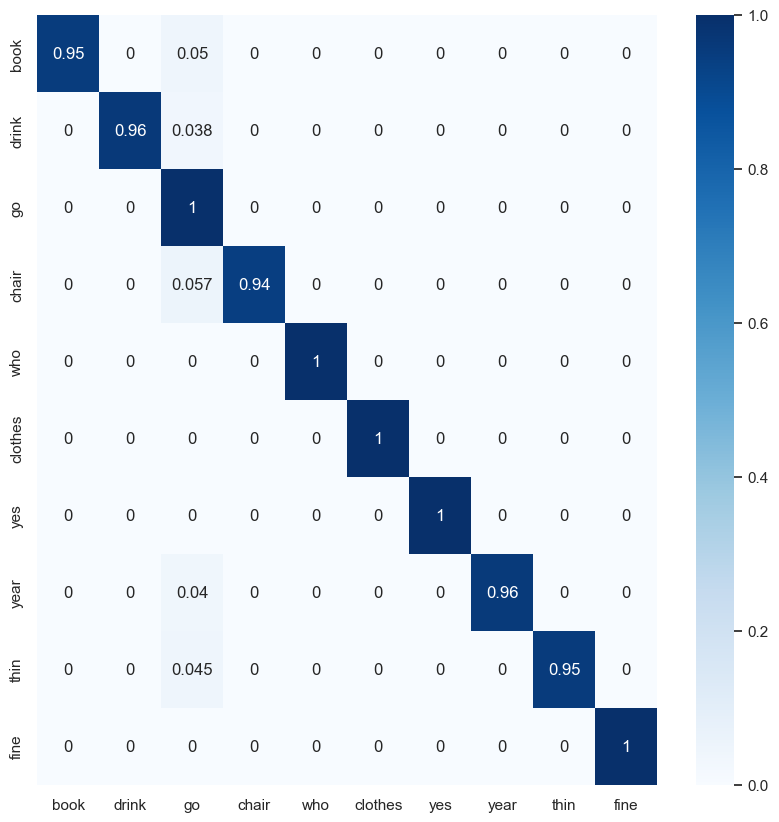

In [12]:
cm_top_5 = confusion_matrix(true_labels, predictions['in_top_5'], normalize='true')
# make seaborn heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm_top_5, annot=True, xticklabels=good_classes, yticklabels=good_classes, cmap='Blues');

Text(0.5, 1.0, 'Top $N$ Accuracy')

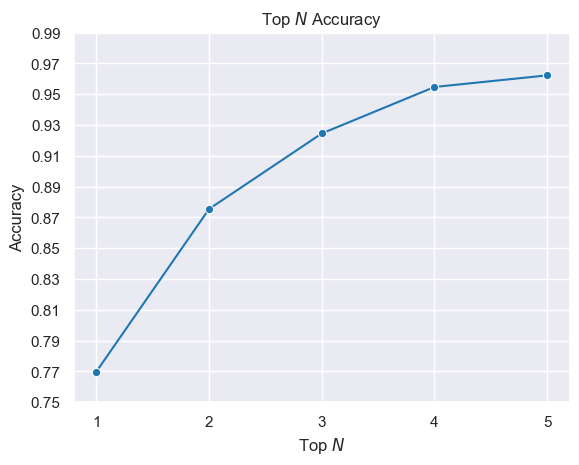

In [29]:
acc = {1: 0.769811320754717, 2: 0.8754716981132076, 3: 0.9245283018867925, 4: 0.9547169811320755, 5: 0.9622641509433962}
sns.lineplot(x=list(acc.keys()), y=list(acc.values()), marker='o')
plt.xticks(range(1, 6))
plt.yticks(np.arange(0.75, 1, 0.02))
plt.xlabel("Top $N$")
plt.ylabel("Accuracy")
plt.title("Top $N$ Accuracy")